<a id='top'></a>
## Analysis of the Tailored Forming Process Chain for the Manufacturing of Hybrid Components
This Jupyter notebook contains several analyses of scholarly knowledge from scientific publications on the topic of *Tailored Forming Process Chain for the Manufacturing of Hybrid Components with Bearing Raceways Using Different Material Combinations* from the research field *Mechanical Process Engineering*. These analyses are based on domain-specific competency questions about the described scholarly knowledge posed by domain experts in this research area. While the individual competency questions are presented below for overview, their details are explained in the respective section of this Jupyter notebook.

Competency questions:
1. [How often are certain qualities of hybrid components examined in the individual steps of the Tailored Forming process chain?](#q1)
2. [Which material combinations are used for the manufacturing of hybrid components?](#q2)
3. [How do the steps of the Tailored Forming process chain affect the hardness of the cladding layer of hybrid components?](#q3)
4. [In which material combinations and steps of the Tailored Forming process chain can defects occur in hybrid components?](#q4)
5. [What service lives can be achieved for hybrid components depending on the material combinations?](#q5)
6. [Which manufacturing methods are used in the individual steps of the Tailored Forming process chain to manufacture the respective hybrid component?](#q6)
7. [How often are certain manufacturing methods used in total in all described Tailored Forming process chains?](#q7)
8. [Which microstructures are present in hybrid components after the steps of the Tailored Forming process chain?](#q8)

For the description of the scholarly knowledge from such publications in this research field, we developed a [ORKG template](https://www.orkg.org/orkg/template/R150595) to consistently describe a Tailored Forming process chain for manufacturing hybrid omponents. An [ORKG template](https://www.orkg.org/orkg/about/19/Templates) defines a semantic structure for consistently describing research contributions of different scientific publications so that the contributions described contain the same information to make the publications comparable.
This description includes the entire process chain with its steps, source materials, and resulting components with their qualities. The template makes it possible to describe each step of a process chain in terms of its sequence in the process chain, its input, its manufacturing method used, and its output with the examined qualities, their associated measurement methods, and measurement results.

## Loading data from ORKG SPAQRL endpoint
First, the data from the publications on *Tailored Forming Process Chain for the Manufacturing of Hybrid Components* is loaded from the Open Research Knowledge Graph ([ORKG](https://www.orkg.org/orkg/)) using the developed template.

In [38]:
%matplotlib widget
import sparql_dataframe
import seaborn as sns
import matplotlib.pyplot as plt
import dataframe_image as dfi

ENDPOINT_URL = "https://www.orkg.org/orkg/triplestore"

PREFIXES =  """
            PREFIX orkgr: <http://orkg.org/orkg/resource/>
            PREFIX orkgc: <http://orkg.org/orkg/class/>
            PREFIX orkgp: <http://orkg.org/orkg/predicate/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            """

query = """
        SELECT ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality ?num_value ?textual_value ?avg_range (xsd:float(?lower_num_value) AS ?min_value) (xsd:float(?upper_num_value) AS ?max_value) ?unit
        WHERE {
                #Get all steps of the Tailored Forming process chains, their manufacturing methods, their resulting hybrid components, and their measurement methods (methods)
                ?contrib_url a orkgc:C21027.
                ?contrib_url orkgp:P7108 ?process_plan;
                        rdfs:label ?contrib.
                ?process_plan orkgp:P44026 ?step_n.
                ?step_n orkgp:P7111 ?step_n_name;
                        orkgp:P44025* ?step_n_plus_1;
                        orkgp:P44012 ?method_n;
                        orkgp:HAS_METHOD ?manufacturing_method_n;
                        orkgp:P30012 ?output_n.
                ?step_n_plus_1 orkgp:P7111 ?step_n_plus_1_name;
                                orkgp:P44012 ?method_n_plus_1;
                                orkgp:HAS_METHOD ?manufacturing_method_n_plus_1;
                                orkgp:P30012 ?output_n_plus_1.
                BIND(IF(?step_n_plus_1 = ?step_n, ?method_n, ?method_n_plus_1) AS ?method_resrc)
                BIND(IF(?step_n_plus_1 = ?step_n, ?manufacturing_method_n, ?manufacturing_method_n_plus_1) AS ?manu_method_resrc)
                BIND(IF(?step_n_plus_1 = ?step_n, ?output_n, ?output_n_plus_1) AS ?output)
                
                #Get all materials and layers of the resulting hybrid components
                ?output orkgp:P28005 ?layer_resrc;
                        orkgp:P7111 ?component_type.
                ?component_type rdfs:label ?component.
                ?layer_resrc orkgp:P3 ?layer_type;
                             orkgp:P7000 ?material_resrc.
                ?layer_type rdfs:label ?layer.
                ?material_resrc orkgp:P42007 ?material_type.
                ?material_type rdfs:label ?material.
                
                #Get the manufacturing method
                ?manu_method_resrc orkgp:P7111 ?manu_method_name.
                ?manu_method_name rdfs:label ?manufacture_method.
                
                #Get the qualities
                Optional{?material_resrc orkgp:P7113 ?quality_resrc.
                        ?quality_resrc orkgp:P7111 ?quality_type;
                                        orkgp:P44022 ?measurement.
                        ?quality_type rdfs:label ?quality.

                        #Get the measurement method
                        Optional{?method_resrc orkgp:P7111 ?method_name;
                                               orkgp:HAS_RESULTS ?measurement.
                                ?method_name rdfs:label ?measure_method.}

                        #Get the range and unit of the resulting component
                        OPTIONAL{?measurement orkgp:P44010 ?range.
                                ?range orkgp:P43248 ?lower_value;
                                        orkgp:P43247 ?upper_value.
                                ?upper_value orkgp:P42000 ?range_unit.
                                ?lower_value orkgp:P44011 ?lower_num_value.
                                ?upper_value orkgp:P44011 ?upper_num_value.}

                        #Get the measurement value and unit of the resulting component
                        OPTIONAL{?measurement orkgp:HAS_VALUE ?value.
                                ?value orkgp:P44011 ?measurement_value.
                                BIND(IF(REGEX(?measurement_value, "^\\\d*\\\.?\\\d*$", "i"), xsd:float(?measurement_value), "") AS ?num_value)
                                BIND(IF(REGEX(?measurement_value, "^\\\d*\\\.?\\\d*$", "i"), "", ?measurement_value) AS ?textual_value)
                                OPTIONAL{?value orkgp:P42000 ?value_unit.}
                                }
                        }
                
                #If no value is reported, calculate the average value based on the reported range
                BIND(IF (BOUND(?value), "", (((xsd:float(?lower_num_value) + xsd:float(?upper_num_value)) / 2) AS ?avg_value) ) AS ?avg_range).
                
                #Get the unit either from the single measurement value or the range
                BIND(IF (BOUND(?value), ?value_unit, ?range_unit) AS ?unit_resrc).
                OPTIONAL {?unit_resrc rdfs:label ?unit.}
                
                #Get the sequence of the step in the process plan
                ?step_n_plus_1_name rdfs:label ?step_name.
                BIND(STR(?step_name) AS ?step)
                VALUES(?step ?step_number){("Deposition welding" 1) ("Hot forming" 2) ("Cooling" 3) ("Heat treatment" 4) ("Machining" 5)}  
        }
        GROUP BY ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality
        ORDER BY ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality
        """
tf_data = sparql_dataframe.get(ENDPOINT_URL, PREFIXES+query)
tf_data.head()

,contrib_url,contrib,component,step_number,step_name,manufacture_method,layer,material,measure_method,quality,num_value,textual_value,avg_range,min_value,max_value,unit
0,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,Hardness profile,Hardness,NaN,NaN,150.0,100.0,200.0,HV0.5
2,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,Micrograph,Microstructure,NaN,ferritic-pearlitic,NaN,NaN,NaN,NaN
3,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Cladding layer,100Cr6,Hardness profile,Hardness,NaN,NaN,400.0,350.0,450.0,HV0.5
4,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Cladding layer,100Cr6,Micrograph,Microstructure,NaN,pearlitic,NaN,NaN,NaN,NaN


<a id='q1'></a>
### 1. Competency question: How often are certain qualities of hybrid components examined in the individual steps of the Tailored Forming process chain?
Based on this question, we want to know which qualities of the manufactured components are typically reported after certain steps of the Tailored Forming process chain. On the one hand, this information shows which qualities are reported prominently in scientific publications on Tailored Forming process chains. On the other hand, the answer to this question also shows in which steps little research has been reported in general and for specific qualities.

[Back to top](#top)

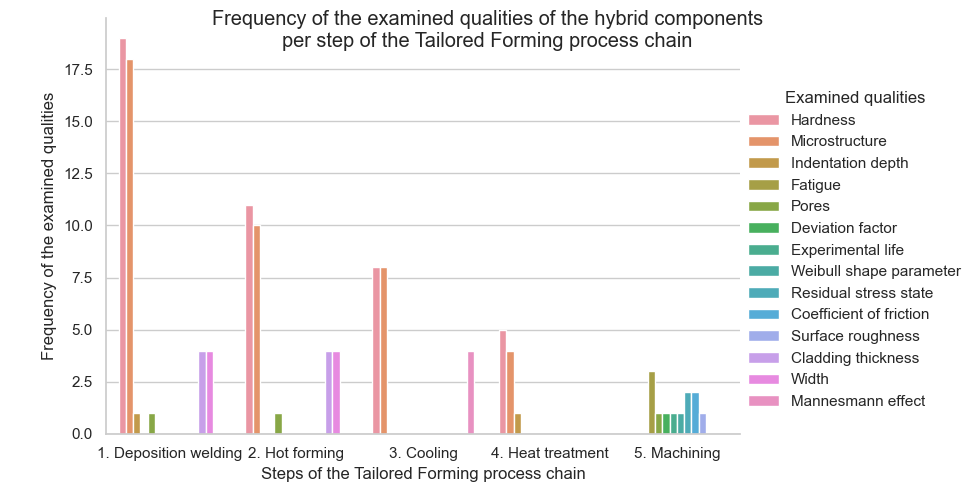

In [39]:
steps = tf_data.sort_values('step_number')[['step_number', 'step_name']].drop_duplicates()
steps["step"] = steps['step_number'].astype(str) + '. ' + steps['step_name']

sns.set_style('whitegrid')
sns.set_context('notebook')
g = sns.catplot(x='step_number', data=tf_data, hue='quality', kind='count', height=5, aspect=1.5, facet_kws={'legend_out': True})
g.fig.suptitle('Frequency of the examined qualities of the hybrid components\nper step of the Tailored Forming process chain')
g.set(xlabel='Steps of the Tailored Forming process chain', ylabel='Frequency of the examined qualities')
g.set_xticklabels(steps['step'])
g._legend.set_title('Examined qualities')
plt.savefig('Images/Frequency of the examined qualities.png', dpi=300)
plt.ion()
plt.show()

<a id='q2'></a>
### 2. Competency question: Which material combinations are used for the manufacturing of hybrid components?
Due to the large number of materials combinations for the manufacturing of hybrid components, it is necessary to know which material combinations have already been investigated for particular hybrid components. On the one hand, this overview allows researchers to find out whether similar studies already exist so that they can compare these results with their own results. On the other hand, with this overview it is possible to find out which materials combinations for certain hybrid components have not yet been studied and thus represent a gap in science that needs to be closed.

[Back to top](#top)

In [43]:
material_data = tf_data.loc[:,['contrib_url','layer', 'material', 'component']].drop_duplicates()
material_table = material_data.pivot(index=['contrib_url', 'component'], columns='layer')
dfi.export(material_table, 'Images/Material comincations used for the manufacturing of hybrid components.png')
material_table

material  \
layer                                                         Base material   
contrib_url                           component                               
http://orkg.org/orkg/resource/R145728 Bearing washer                  C22.8   
http://orkg.org/orkg/resource/R145731 Bearing washer                  C22.8   
http://orkg.org/orkg/resource/R145734 Bearing washer                   S235   
http://orkg.org/orkg/resource/R162733 Shaft with bearing seat         C22.8   
http://orkg.org/orkg/resource/R162788 Shaft with bearing seat         C22.8   
http://orkg.org/orkg/resource/R162790 Shaft with bearing seat         C22.8   
http://orkg.org/orkg/resource/R171849 Shaft with bearing seat       20MnCr5   
http://orkg.org/orkg/resource/R172160 Shaft with bearing seat       20MnCr5   
http://orkg.org/orkg/resource/R172247 Shaft with bearing seat       20MnCr5   
http://orkg.org/orkg/resource/R172322 Shaft with bearing seat       20MnCr5   

                                                                              
layer                                                         Cladding layer  
contrib_url                           component                               
http://orkg.org/orkg/resource/R145728 Bearing washer                  100Cr6  
http://orkg.org/orkg/resource/R145731 Bearing washer                   41Cr4  
http://orkg.org/orkg/resource/R145734 Bearing washer              X45CrSi9-3  
http://orkg.org/orkg/resource/R162733 Shaft with bearing seat   Delcrome 253  
http://orkg.org/orkg/resource/R162788 Shaft with bearing seat     Stellite 6  
http://orkg.org/orkg/resource/R162790 Shaft with bearing seat         100Cr6  
http://orkg.org/orkg/resource/R171849 Shaft with bearing seat     X45CrSi9-3  
http://orkg.org/orkg/resource/R172160 Shaft with bearing seat     X45CrSi9-3  
http://orkg.org/orkg/resource/R172247 Shaft with bearing seat     X45CrSi9-3  
http://orkg.org/orkg/resource/R172322 Shaft with bearing seat     X45CrSi9-3

<a id='q3'></a>
### 3. Competency Question: How do the steps of the Tailored Forming process chain affect the hardness of the cladding layer of hybrid components?
The hardness of the cladding layer is an important measure for assessing the suitability of the cladding for mechanically or tribologically highly stressed component areas. For this reason, the question arises as to how the individual steps of the Tailored Forming process chain affect the hardness in the cladding layer of a hybrid component.

[Back to top](#top)

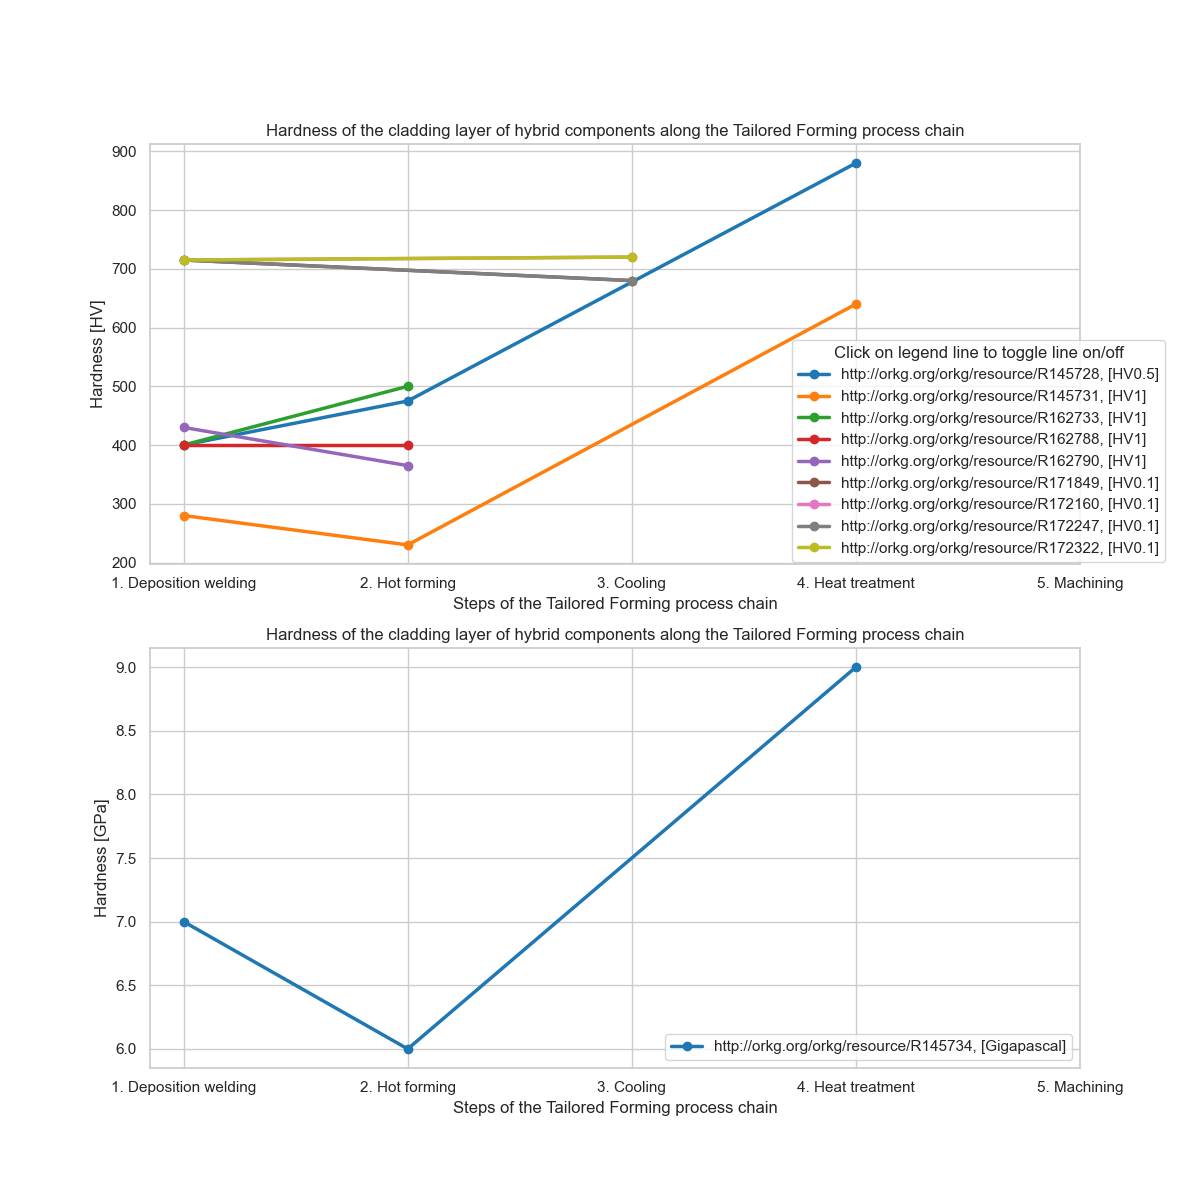

In [44]:
tf_data['calc_value'] = tf_data['num_value'].fillna(tf_data['avg_range'])
hardness_data = tf_data.query('quality == "Hardness" and layer == "Cladding layer"')[['contrib_url','step_number', 'step_name', 'calc_value', 'unit']]
grouped_hardness = hardness_data.groupby('contrib_url')

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(12, 12)

lines = []
for name, group in grouped_hardness:
    if (group['unit'][:1].item() != 'Gigapascal') :
        line, = ax1.plot(group['step_number'], group['calc_value'], marker='o', linewidth=2.5, label=name+', ['+group['unit'][:1].item()+']')
        lines.append(line)
    else:
        ax2.plot(group['step_number'], group['calc_value'], marker='o', linewidth=2.5, label=name+', ['+group['unit'][:1].item()+']')
        
ax1.set_title('Hardness of the cladding layer of hybrid components along the Tailored Forming process chain')
ax1.set_xticks(steps['step_number'])
ax1.set_xticklabels(steps['step'])
ax1.set_xlabel('Steps of the Tailored Forming process chain')
ax1.set_ylabel('Hardness [HV]')
legend1 = ax1.legend(loc='center right', bbox_to_anchor=(1.1, 0.27))
legend1.set_title('Click on legend line to toggle line on/off')

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(legend1.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(5)
    lined[legline] = origline


def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

ax2.set_title('Hardness of the cladding layer of hybrid components along the Tailored Forming process chain')
ax2.set_xticks(steps['step_number'])
ax2.set_xticklabels(steps['step'])
ax2.set_xlabel('Steps of the Tailored Forming process chain')
ax2.set_ylabel('Hardness [GPa]')
legend2 = ax2.legend(loc='lower right')

plt.connect('pick_event', on_pick)
plt.savefig('Images/Hardness in the cladding layer.png', dpi=300)
plt.show()

<a id='q4'></a>
## 4. Question: In which material combinations and steps of the Tailored Forming process chain can defects occur in hybrid components?

[Back to top](#top)

In [45]:
defects_data = tf_data[((tf_data.quality == 'Pores') | (tf_data.quality == 'Mannesmann effect') | (tf_data.quality == 'Cracks')) & (tf_data.textual_value == 'true')][['contrib_url', 'component', 'layer', 'material', 'quality', 'step_name', 'step_number']]
defects_data_complete = defects_data.merge(tf_data, on=['contrib_url', 'step_name'], how='left')[['contrib_url', 'component_x', 'layer_x', 'material_x', 'layer_y', 'material_y', 'quality_x', 'step_name', 'step_number_x']].drop_duplicates()

to_delete = defects_data_complete[defects_data_complete.layer_x == defects_data_complete.layer_y]
final_defect_df = defects_data_complete.drop(to_delete.index, inplace=False)
final_defect_df.rename(columns= {'component_x':'component','layer_x':'layer_with_defect','material_x':'material_with_defect', 'layer_y':'other_layer', 'material_y':'other_material', 'quality_x':'defect', 'step_number_x':'step_number'})
#dfi.export(material_table, 'Images/Material comincations used for the manufacturing of hybrid components.png')

,contrib_url,component,layer_with_defect,material_with_defect,other_layer,other_material,defect,step_name,step_number
0,http://orkg.org/orkg/resource/R145728,Bearing washer,Cladding layer,100Cr6,Base material,C22.8,Pores,Machining,5
9,http://orkg.org/orkg/resource/R145731,Bearing washer,Cladding layer,41Cr4,Base material,C22.8,Pores,Deposition welding,1
15,http://orkg.org/orkg/resource/R145731,Bearing washer,Cladding layer,41Cr4,Base material,C22.8,Pores,Hot forming,2
24,http://orkg.org/orkg/resource/R171849,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3
30,http://orkg.org/orkg/resource/R172160,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3
36,http://orkg.org/orkg/resource/R172247,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3
42,http://orkg.org/orkg/resource/R172322,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3


<a id='q5'></a>
## 5. Question: What service lives can be achieved for hybrid components depending on the material combinations?

[Back to top](#top)

In [ ]:
fatigue_data = tf_data[(tf_data.quality == 'Fatigue') & (tf_data.step_number == 5)][['contrib_url', 'component', 'calc_value', 'unit']]

g = sns.catplot(x='calc_value', y='contrib_url', data=fatigue_data, kind='bar', height=5, aspect=1.8, facet_kws={'legend_out': True})
g.fig.suptitle('Lifetimes of the manufactured components', y=1.0)
g.set(xlabel='Lifetime [h]', ylabel='Components')
plt.savefig('Images/Lifetimes of the manufactured components.png', dpi=300)
plt.show()

<a id='q6'></a>
## 6. Question: Which manufacturing methods are used in the individual steps of the Tailored Forming process chain to manufacture the respective hybrid component?

[Back to top](#top)

In [ ]:
method_data = tf_data.loc[:,['contrib_url','component', 'step_number', 'step_name', 'manufacture_method']].drop_duplicates().sort_values('step_number')
method_data.pivot(index=['contrib_url', 'component'], columns=['step_number', 'step_name'], values='manufacture_method').fillna('--', inplace=False)

<a id='q7'></a>
## 7. Question: How often are certain manufacturing methods used in total in all described Tailored Forming process chains?

[Back to top](#top)

In [ ]:
g = sns.catplot(y='manufacture_method', data=method_data, kind='count', height=5, aspect=2.3, facet_kws={'legend_out': True})
g.fig.suptitle('Frequency of the applied manufacturing methods in all tailoted forming process described', y=1.0)
g.set(xlabel='Frequency of the applied manufacturing method', ylabel='Manufacturing methods')
plt.savefig('Images/Frequency of the applied manufacturing methods.png', dpi=300)
plt.show()

<a id='q8'></a>
## 8. Question: Which microstructures are present in hybrid components after the steps of the Tailored Forming process chain?

[Back to top](#top)

In [ ]:
microstructure_data = tf_data[tf_data.quality == 'Microstructure'][['contrib_url', 'component', 'layer', 'material', 'textual_value', 'step_name', 'step_number']]
microstructure_data